In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <font color='red'>Part 1: Loading Dataset<font color='red'> 📦

### Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

### Set Path and Directories

In [ ]:
# Set the path to the dataset
data_dir = Path('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/')

data_dir

# Specify directories for normal and tuberculosis cases
normal_cases_dir = data_dir / 'Normal'
Tuberculosis_cases_dir = data_dir / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases = Tuberculosis_cases_dir.glob('*.png')

### Load Image Paths and Labels

In [ ]:
# Create lists to store image paths and labels
train_data = []

# Load image paths and assign labels for normal cases (label: 0)
for img in normal_cases_dir.glob('*.png'):
    train_data.append((img, 0))

# Load image paths and assign labels for tuberculosis cases (label: 1)
for img in Tuberculosis_cases_dir.glob('*.png'):
    train_data.append((img, 1))

### Create DataFrame, Shuffle Data, and Display Class Distribution

In [ ]:
# Create a DataFrame from the list
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Display class distribution
cases_count = train_data['label'].value_counts()
print(cases_count)

# How the dataframe looks like?
train_data.head()

### Plot Class Distribution

In [ ]:
# Plot class distribution
plt.figure(figsize=(10, 8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

# <font color='red'>Part 2: Data Preprocessing<font color='red'> 🧐

### Get Few Samples for Both Classes and Plot Data

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concatenate the data in a single list and delete the above two lists
samples = Tuberculosis_samples + normal_samples
del Tuberculosis_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i%5].set_title("Tuberculosis")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Data Preprocessing

In [43]:
# Define directories for normal and tuberculosis cases
normal_cases_dir = data_dir / 'Normal'
Tuberculosis_cases_dir = data_dir / 'Tuberculosis'

# Initialize lists for data and labels
train_data = []
train_labels = []

# Load and preprocess normal cases
for img in tqdm(normal_cases_dir.glob('*.png')):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28, 28))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) / 255
    label = 'normal'
    train_data.append(img)
    train_labels.append(label)

# Load and preprocess tuberculosis cases
for img in tqdm(Tuberculosis_cases_dir.glob('*.png')):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28, 28))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) / 255
    label = 'Tuberculosis'
    train_data.append(img)
    train_labels.append(label)

# Convert lists to numpy arrays
train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

3500it [00:32, 106.41it/s]
700it [00:06, 114.84it/s]

Total number of validation examples:  (4200, 28, 28, 3)
Total number of labels: (4200,)


In [44]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,normal
1,normal
2,normal
3,normal
4,normal


In [45]:
train_labels1['label']=train_labels1['label'].map({'normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

### Reshape Data and Perform SMOTE Oversampling

Class distribution after SMOTE:
label
0    3500
1    3500
Name: count, dtype: int64


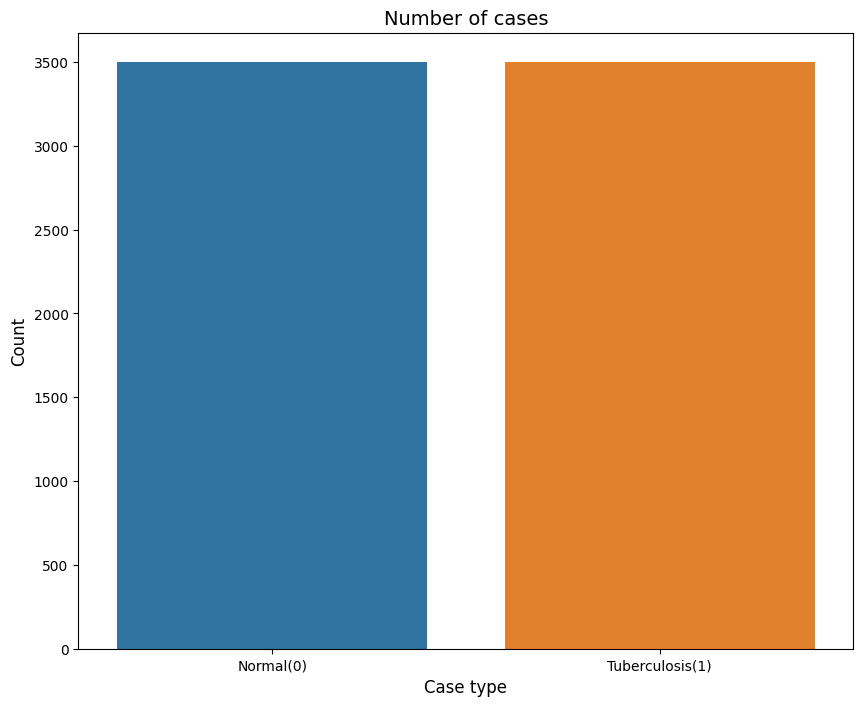

In [46]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE

# Initialize SMOTE (Synthetic Minority Over-sampling Technique)
smt = SMOTE()

# Get the number of rows in the original training data
train_rows = len(train_data1)

# Reshape the original training data to 1D array (flattening)
train_data1 = train_data1.reshape(train_rows, -1)

# Apply SMOTE to generate synthetic samples for balancing classes
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

# Count class distribution after applying SMOTE
cases_count1 = train_labels2['label'].value_counts()

# Print the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(cases_count1)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count1.index, y= cases_count1.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

### Prepare Data for Model Training

In [47]:
# Reshape data back to image dimensions
train_data2 = train_data2.reshape(-1, 28, 28, 3)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.13, random_state=42)

# <font color='red'>3. Modelling<font color='red'> 🤖

### Data Augmentation Setup

In [48]:
# Set up data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(28, 28, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [49]:

# Initialize the model
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu')
])

# Display model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)         

In [50]:
# Add dense layers to the model
model.add(layers.Flatten())
model.add(layers.Dense(640, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(564, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(2))

# Display updated model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)         

In [ ]:
# Train the model
model.fit(np.array(X_train), np.array(y_train), epochs=200, validation_data=(np.array(X_test), np.array(y_test)))

# <font color='red'>4. Model Evaluation<font color='red'> 📊

In [ ]:
# Train the model with history to track metrics
history = model.fit(np.array(X_train), np.array(y_train), epochs=200, validation_data=(np.array(X_test), np.array(y_test)))

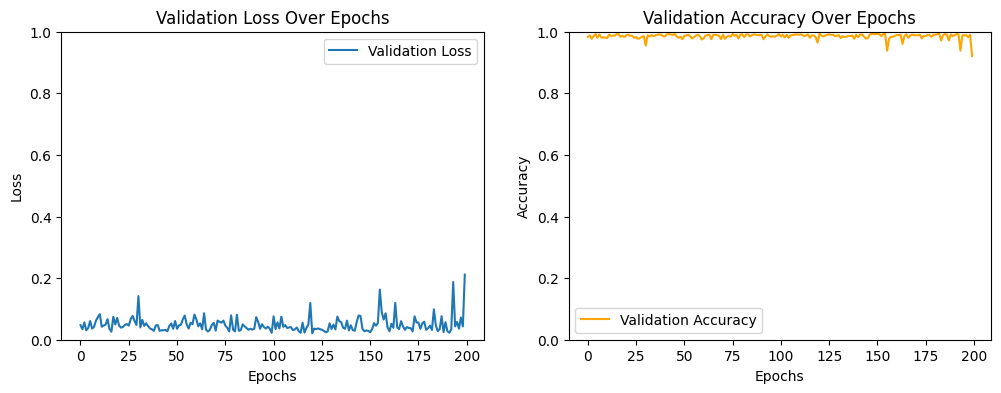

29/29 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       475
           1       1.00      0.83      0.91       435

    accuracy                           0.92       910
   macro avg       0.93      0.92      0.92       910
weighted avg       0.93      0.92      0.92       910



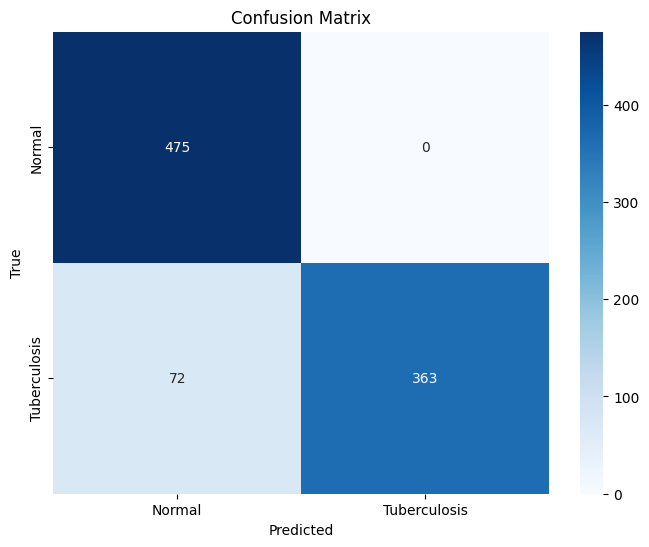

In [57]:
# Plot validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.legend()
plt.show()

# Predict on the test set
y_pred = np.argmax(model.predict(np.array(X_test)), axis=1)

# Generate classification report
class_report = classification_report(np.array(y_test), y_pred)
print("Classification Report:")
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(np.array(y_test), y_pred)

# Plot heatmap of confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()